In [2]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [3]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [4]:
os.chdir(config["PATH"]["project"])
project_path = config["PATH"]["project"]

Create spark session. Add driver postgress to enable to load from existing postgres DB


In [5]:
# add driver postgress to enable to load from existing postgres DB
spark = SparkSession \
    .builder \
    .appName("covid_weather") \
    .config("spark.jars", "postgresql-42.2.18.jar")\
    .config( "spark.driver.extraClassPath", "postgresql-42.2.18.jar")\
    .getOrCreate()

In [6]:
data_root = os.path.join(project_path, 'DATA/')

In [7]:
nyt = pd.read_csv( os.path.join(data_root, "us-counties.txt") )
nyt = nyt.astype( {"fips" : 'Int64', "deaths": 'Int64'})
nyt.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [8]:
nyt.shape

(1124916, 6)

## Daily cases

From cumulated cases an deaths, get the daily cases

In [9]:
nyt.sort_values([ "state", "fips","county", "date"] , inplace = True)
nyt.index = range(len(nyt))

Check whether there are NaN values in cases or deaths

In [10]:
nyt[nyt["cases"].isna()]

,date,county,state,fips,cases,deaths


In [11]:
nyt[nyt["deaths"].isna()]

,date,county,state,fips,cases,deaths
809610,2020-05-05,Adjuntas,Puerto Rico,72001,3,<NA>
809611,2020-05-06,Adjuntas,Puerto Rico,72001,3,<NA>
809612,2020-05-07,Adjuntas,Puerto Rico,72001,3,<NA>
809613,2020-05-08,Adjuntas,Puerto Rico,72001,3,<NA>
809614,2020-05-09,Adjuntas,Puerto Rico,72001,3,<NA>
...,...,...,...,...,...,...
834138,2021-03-11,Yauco,Puerto Rico,72153,1008,<NA>
834139,2021-03-12,Yauco,Puerto Rico,72153,1008,<NA>
834140,2021-03-13,Yauco,Puerto Rico,72153,1008,<NA>
834141,2021-03-14,Yauco,Puerto Rico,72153,1007,<NA>


In [12]:
nyt[nyt["deaths"].isna()]["state"].value_counts()

Puerto Rico    24533
Name: state, dtype: int64

In [13]:
len(nyt[nyt["state"] == "Puerto Rico"] )

24901

In [14]:
nyt[ (~nyt["deaths"].isna()) & (nyt["state"] == "Puerto Rico")]

,date,county,state,fips,cases,deaths
834143,2020-03-13,Unknown,Puerto Rico,<NA>,3,0
834144,2020-03-14,Unknown,Puerto Rico,<NA>,4,0
834145,2020-03-15,Unknown,Puerto Rico,<NA>,5,0
834146,2020-03-16,Unknown,Puerto Rico,<NA>,5,0
834147,2020-03-17,Unknown,Puerto Rico,<NA>,5,0
...,...,...,...,...,...,...
834506,2021-03-11,Unknown,Puerto Rico,<NA>,4463,2073
834507,2021-03-12,Unknown,Puerto Rico,<NA>,4468,2077
834508,2021-03-13,Unknown,Puerto Rico,<NA>,4476,2077
834509,2021-03-14,Unknown,Puerto Rico,<NA>,4478,2080


In Puerto Rico, cases are reported by county but deaths are global for the territory

In [15]:
group_nyt = nyt.groupby(["county", "state", "fips"], dropna = False)

In [16]:
nyt["daily_cases"] = group_nyt["cases"].diff().fillna( nyt["cases"])
nyt["daily_deaths"] = group_nyt["deaths"].diff().fillna( nyt["deaths"])

In [17]:
nyt[ nyt["daily_deaths"]< 0]["daily_deaths"].value_counts().sort_index()

-512       1
-299       1
-275       1
-234       1
-206       1
        ... 
-5        78
-4       137
-3       168
-2       496
-1      4041
Name: daily_deaths, Length: 79, dtype: Int64

In [18]:
nyt[ nyt["daily_deaths"] == -512]

,date,county,state,fips,cases,deaths,daily_cases,daily_deaths
650041,2020-08-06,Nassau,New York,36059,43534,2194,52.0,-512


<AxesSubplot:xlabel='date'>

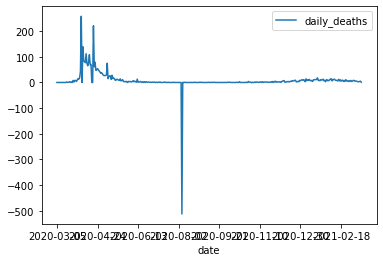

In [19]:
nyt[ nyt["fips"] == 36059 ].plot( x = "date", y = "daily_deaths")

In [20]:
deaths_anomalies = nyt[ nyt["daily_deaths"] < -100][["state", "fips", "county", "daily_deaths"]].sort_values("daily_deaths")
deaths_anomalies

,state,fips,county,daily_deaths
650041,New York,36059,Nassau,-512
661195,New York,<NA>,Unknown,-299
247341,Illinois,<NA>,Unknown,-275
414552,Louisiana,<NA>,Unknown,-234
836378,Rhode Island,<NA>,Unknown,-206
742274,Ohio,39153,Summit,-155
836354,Rhode Island,<NA>,Unknown,-148
659875,New York,36119,Westchester,-132
836651,Rhode Island,<NA>,Unknown,-124
836408,Rhode Island,<NA>,Unknown,-120


In [26]:
deaths_anomalies_2 = deaths_anomalies[ deaths_anomalies.columns[0:-1]].drop_duplicates()
deaths_anomalies_2

,state,fips,county
650041,New York,36059,Nassau
661195,New York,<NA>,Unknown
247341,Illinois,<NA>,Unknown
414552,Louisiana,<NA>,Unknown
836378,Rhode Island,<NA>,Unknown
742274,Ohio,39153,Summit
659875,New York,36119,Westchester


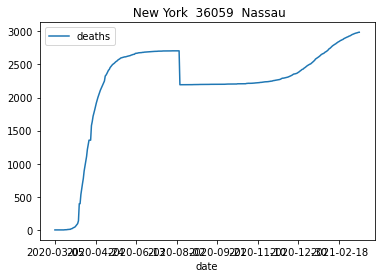

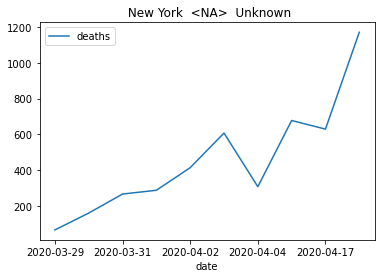

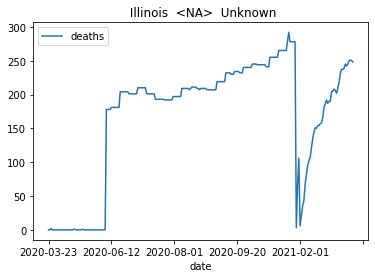

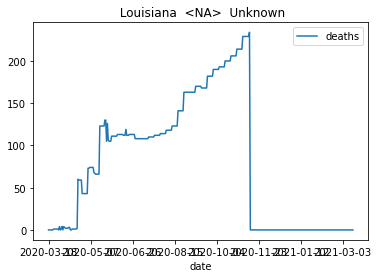

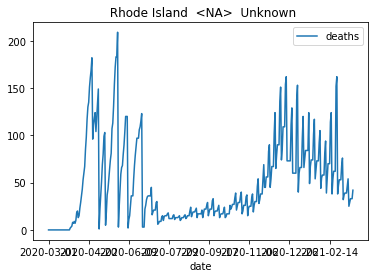

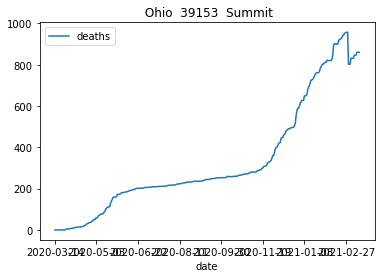

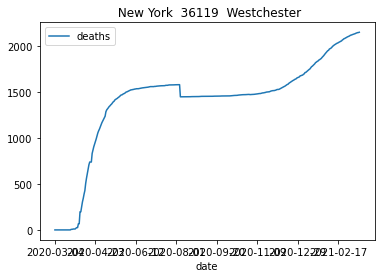

In [27]:
for i in range( len(deaths_anomalies_2)):
    df_merge = pd.merge( nyt, deaths_anomalies_2.iloc[i:i+1], on =["state", "fips", "county"])
    titel = deaths_anomalies_2.iloc[i:i+1].to_string(header = False, index = False)
    df_merge.plot( x = "date", y = "deaths", title = titel)

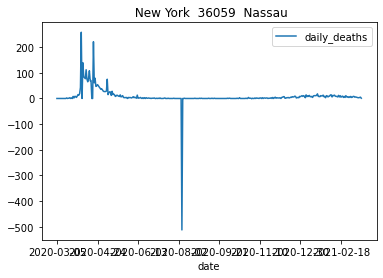

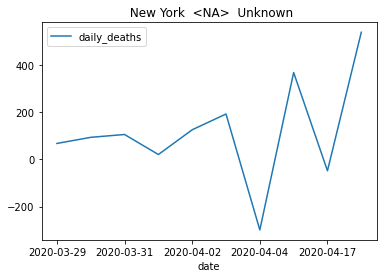

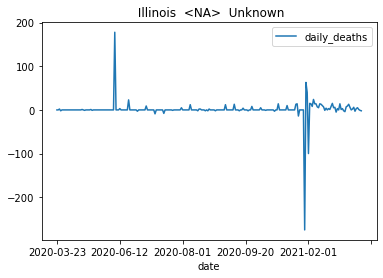

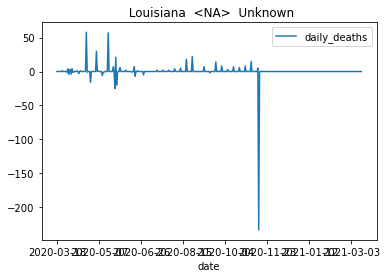

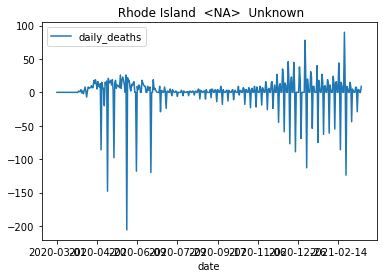

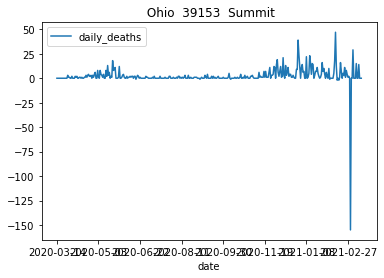

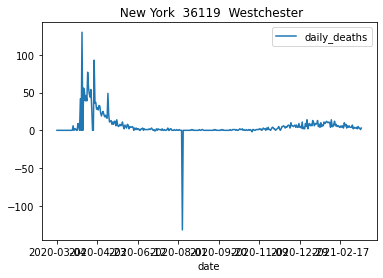

In [28]:
for i in range( len(deaths_anomalies_2)):
    df_merge = pd.merge( nyt, deaths_anomalies_2.iloc[i:i+1], on =["state", "fips", "county"])
    titel = deaths_anomalies_2.iloc[i:i+1].to_string(header = False, index = False)
    df_merge.plot( x = "date", y = "daily_deaths", title = titel)

In [45]:
rhodeisland = nyt[nyt["state"] == "Rhode Island"].groupby("date", dropna = False)[["cases", "deaths"]].sum()

In [51]:
rhodeisland["daily_deaths"] = rhodeisland["deaths"] - rhodeisland["deaths"].shift(fill_value = 0)
rhodeisland["daily_cases"] = rhodeisland["cases"] - rhodeisland["cases"].shift(fill_value = 0)

0
-130


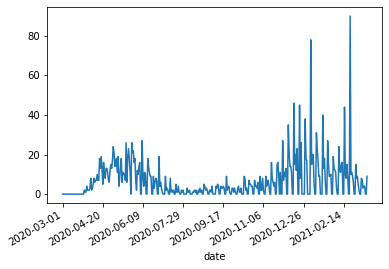

In [59]:
print(rhodeisland["daily_deaths"].min())
print(rhodeisland["daily_cases"].min())
ax = rhodeisland["daily_deaths"].plot()
plt.gcf().autofmt_xdate()

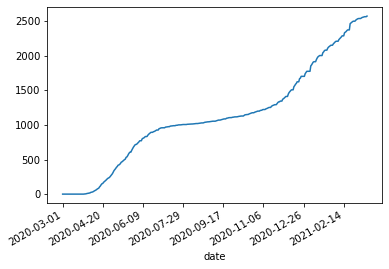

In [60]:
rhodeisland["deaths"].plot()
plt.gcf().autofmt_xdate()

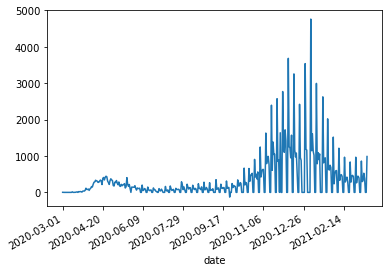

In [61]:
rhodeisland["daily_cases"].plot()
plt.gcf().autofmt_xdate()

In [64]:
pd.date_range("2020-12-01", "2020-12-31", freq = "D")

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq='D')

In [74]:
new_index = pd.to_datetime(rhodeisland.index)
rhodeisland.set_index( new_index, inplace = True)

In [75]:
rhodeisland.loc[ pd.date_range("2020-12-01", "2020-12-31", freq = "D"), "daily_cases"]

2020-12-01    1183
2020-12-02    1099
2020-12-03    1717
2020-12-04    1415
2020-12-05       0
2020-12-06       0
2020-12-07    3681
2020-12-08    1249
2020-12-09    1232
2020-12-10     948
2020-12-11    1571
2020-12-12       0
2020-12-13       0
2020-12-14    3253
2020-12-15    1166
2020-12-16     972
2020-12-17    1081
2020-12-18     522
2020-12-19       0
2020-12-20       0
2020-12-21    2419
2020-12-22     956
2020-12-23     879
2020-12-24       0
2020-12-25       0
2020-12-26       0
2020-12-27       0
2020-12-28    3536
2020-12-29    1187
2020-12-30    1160
2020-12-31       0
Freq: D, Name: daily_cases, dtype: int64

In [39]:
nyt[nyt["state"] == "Rhode Island"][ "county"].value_counts(dropna = False)

Unknown       380
Washington    356
Newport       356
Providence    356
Bristol       356
Kent          356
Name: county, dtype: int64

In [40]:
nyt[nyt["state"] == "Rhode Island"][ "fips"].value_counts(dropna = False)

NaN      380
44001    356
44003    356
44005    356
44007    356
44009    356
Name: fips, dtype: Int64